$$
\newcommand{\ped}[1]{_{\mathrm{#1}}}
\newcommand{\ap}[1]{^{\mathrm{#1}}}
\newcommand{\nvector}[1]{\mathbf{#1}}
\newcommand{\nmatrix}[1]{\mathit{#1}}
\newcommand{\unitvector}[1]{\hat{\nvector{e}}_{#1}}
\newcommand{\volume}{\mathcal{V}}
\newcommand{\average}[1]{\overline{#1}}
\newcommand{\rate}[1]{\dot{#1}}
\newcommand{\flux}[1]{{#1}''}
\newcommand{\curl}[1]{\nabla\times {#1}}
\newcommand{\curlv}[1]{\curl{\nvector{#1}}}
\newcommand{\divergent}[1]{\nabla \cdot #1}
\newcommand{\divergentv}[1]{\divergent{\nvector{#1}}}
\newcommand{\divergentpar}[1]{\divergent{\left( #1 \right)}}
\newcommand{\gradient}[1]{\nabla {#1}}
\newcommand{\gradientpar}[1]{\gradient{\left( {#1} \right)}}
\newcommand{\laplacian}[1]{\nabla^2 #1}
\newcommand{\laplacianpar}[1]{\laplacian{\left( #1 \right)}}
\newcommand{\vectornorm}[1]{\left\lVert #1 \right\rVert}
\newcommand{\diffp}[2]{\frac{\partial {#1}}{\partial {#2}}}
\newcommand{\diffps}[2]{\frac{\partial^2 {#1}}{\partial {#2}^2}}
\newcommand{\rvec}{\nvector{r}}
\newcommand{\nvh}{\nvector{H}}
\newcommand{\nvb}{\nvector{B}}
\newcommand{\nvrem}{\nvector{B}\ped{rem}}
\newcommand{\nvbrem}{\nvrem}
\newcommand{\nvm}{\nvector{M}}
\newcommand{\mur}{\mu\ped{r}}
\newcommand{\nvbremhat}{\hat{\nvector{B}}\ped{rem}}
\newcommand{\acoef}[2]{a_{{#1},\mathrm{#2}}}
\newcommand{\bcoef}[2]{b_{{#1},\mathrm{#2}}}
\newcommand{\Azexpr}[1]{A_{\mathrm{#1}\, z}}
\newcommand{\bremii}{B_{\mathrm{rem,II}}}
\newcommand{\bremiv}{B_{\mathrm{rem,IV}}}
\newcommand{\aIII}{\acoef{1}{III}}
\newcommand{\bIII}{\bcoef{1}{III}}
\newcommand{\nvbIII}{\nvector{B}\ped{III}}
\newcommand{\BIII}{B\ped{III}}
\newcommand{\diffd}[1]{\mathrm{d}\,{#1}}
$$

# TeslaMax Optimization

Teslamax model:

<img src="figures/teslamax.png" width=500>

We are intererested in finding the optimal set of remanence angles $\alpha_{\mathrm{rem},m,k}$ that will maximize some metric in the air gap.

In [1]:
from pathlib import Path
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel



mpl_params = {'text.usetex': True,
              'font.family': 'serif',
              'font.serif': 'Computer Modern',
              'text.latex.preamble': [r'\usepackage{engsymbols}',
                                      r'\usepackage{magref}',
                                      r'\usepackage{siunitx}']}
matplotlib.rcParams.update(mpl_params)

In [2]:
FIGSIZE_CM = 20
FIGSIZE_INCHES = FIGSIZE_CM / 2.54

FONTSIZE = 20



PAPER_FILE_PATH = Path('.')
FIGURES_DIR_NAME = "figures"
FIG_FILE_PATH = PAPER_FILE_PATH / Path(FIGURES_DIR_NAME)


PLOT_EXTENSION = ".png"

DPI = 800

In [14]:
os.chdir(str(Path.home() / "code" / "TeslaMax"))

In [19]:
os.getcwd()

'C:\\Users\\Fabio\\code\\TeslaMax\\teslamax-optimization\\teslamax-optimization'

In [5]:
def save_figure(fig,name):
    """
    Save the 'fig' Figure object as 'name' (with extension PLOT_EXTENSION), inside FIG_FILE_PATH,
    and close the figure"""
    
    
    file_path = str(FIG_FILE_PATH / (name + PLOT_EXTENSION))
    fig.savefig(file_path,dpi=DPI,bbox_inches='tight')

## Parameters

This is reference set of parameters that we use to test the optimization procedures:

In [16]:
params_optimization_reference = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

alpha_B_rem_reference = [15,30,45,15,45,135]


## Principle of superposition and the contribution of each segment

The code below calculate the individual contributions for each magnet block. For instance, the i-th element of the variable `F_II_x` is a list of points in the form $(B_x, B_y)$, calculated in a mesh in the air gap, where only the i-th segment in magnet II has a non-null remanence, with magnitude included in the above dictionary and oriented in the $x$ direction.

This code generates a "mesh" in the upper half-circle (corresponding to the model that is actually simulated by COMSOL), and calculate the $F$-operators in this mesh

In [7]:
%pdb off

Automatic pdb calling has been turned OFF


In [ ]:
%xmode verbose

tmpd_reference = TeslaMaxPreDesign(params_optimization_reference)

F_II_x, F_II_y, F_IV_x, F_IV_y = tmpd_reference.get_F_operators()

Exception reporting mode: Verbose
*******************************************
***COMSOL 5.3.0.223 progress output file***
*******************************************
Thu Jun 01 15:31:42 CEST 2017
COMSOL 5.3 (Build: 223) starting in batch mode
Running: C:\Users\Fabio\code\teslamax\java\TeslaMax.class
---------- Current Progress: 100 % - Updating selections
Memory: 315/324 480/487
           Current Progress:   0 % - Circle 1
Memory: 313/324 475/487
           Current Progress:   8 % - Circle 2
Memory: 317/324 478/487
-          Current Progress:  17 % - Difference 1
---------  Current Progress:  93 % - Resolving domains
Memory: 313/324 473/487
           Current Progress:   0 % - Circle 1
Memory: 315/324 475/487
           Current Progress:   8 % - Circle 2
Memory: 316/324 477/487
-          Current Progress:  17 % - Difference 1
Memory: 317/324 477/487
---------  Current Progress:  93 % - Resolving domains
           Current Progress:   0 % - Cylinder Block - Iron II Wedge 1Q
Memory: 3

Each of of the $F$-operators is a list of points, corresponding to the vector field $\nvb$ calculated at `points_air_gap`:

In [9]:
F_IV_x[0]

array([[  5.61631883e-01,   1.17754618e-03],
       [  5.60459197e-01,   5.15190544e-03],
       [  5.59308337e-01,   9.33609103e-03],
       ..., 
       [  5.55285619e-01,   3.04506689e-03],
       [  5.54977246e-01,   1.46271612e-03],
       [  5.54690620e-01,  -1.36431085e-04]])

## Calculating the functional

The basic computational implementation of optimization algorithms require evaluate an *objective functional*. In this formulation, the main optimization variables are the angles, which are always represented by the vector `alpha_B_rem`. Notice that, in order to efficiently calculate the functional, we have to pass the lists of $F$-operators that we calculated previously, the points where these operators are calculated, and the dictionary of parameters.

Our goal is to build an instantaneous profile. This function calculates it:

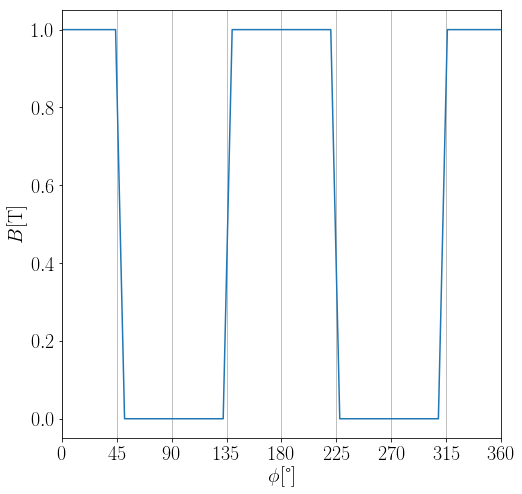

In [11]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig_inst = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes_inst = profile_fig_inst.add_subplot(111)

phi_inst_vector = np.linspace(0,360)
B_inst_vector = teslamax.calculate_instantaneous_profile(phi_inst_vector,1.0)


profile_axes_inst.plot(phi_inst_vector,B_inst_vector)
profile_axes_inst.set_xlim(0,np.max(phi_inst_vector))
profile_axes_inst.set_xticks(np.linspace(0,np.max(phi_inst_vector),9))
profile_axes_inst.xaxis.grid(True)
profile_axes_inst.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes_inst.set_ylabel(r'$B [\si{\tesla}]$')




An example of calculation:

In [12]:
S_0 = tmpd_reference.calculate_functional(alpha_B_rem_reference)
print(S_0)

31.5345887432


Another piece of optimization algorithm is a function to calculate the derivative of the funcional:

In [13]:
dS_0 = tmpd_reference.calculate_functional_derivative(alpha_B_rem_reference, 2)
print(dS_0)

0.130833321066


## Optimization algorithm

This is a prototype of an implementation of the gradient descent algorithm from Insinga (2016):

In [ ]:
params_optimization = {"R_i": 0.015,
                "R_o": 0.060,
                "h_gap": 0.030,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }
alpha_B_rem_0 = [15,30,45,15,45,135]

tmpd = TeslaMaxPreDesign(params_optimization)

S_0 = tmpd.calculate_functional(alpha_B_rem_0)

gamma = 1e5
max_iter = 50
tol = 1e-6

i = 0
alpha_B_rem = alpha_B_rem_0.copy()
S_old = S_0

for i in range(0,len(alpha_B_rem)):
    
    it_count = 0
    
    
    while True:
        
        dSdalpha = tmpd.calculate_functional_derivative(alpha_B_rem, i)
        
        dalpha = gamma * dSdalpha
        alpha_B_rem[i] = alpha_B_rem[i] + dalpha
        
        S = tmpd.calculate_functional(alpha_B_rem)
        
        dS_rel = abs((S - S_old)/S)
        S_old = S
        
        
        it_count = it_count + 1
        
        max_iter_reached = it_count >= max_iter
        converged = dS_rel < tol
        
        if converged or max_iter_reached:
            break
            
    print("alpha[%d] = %.2f, S = %.7f" %(i, alpha_B_rem[i],S))


Checking optimality conditions:

In [ ]:
grad_alpha_optimal = tmpd.calculate_functional_gradient(alpha_B_rem)
print(grad_alpha_optimal)

In [ ]:
hessian_alpha_optimal = tmpd.calculate_functional_hessian(alpha_B_rem)
print(np.linalg.eigvals(hessian_alpha_optimal))


We can see that the calculated point is far from optimal, because it is not a stationary point (its gradient is not null) and the hessian matrix is indefinite.

To compare, we plot the magnetic profiles before and after the optimization:

In [ ]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)


teslamax_playground = 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax-play'
tmpd_reference = TeslaMaxPreDesign(params_optimization)

tmm_reference = TeslaMaxModel(tmpd_reference,alpha_B_rem_0,
                   path=teslamax_playground)
tmm_reference.run()
phi_vector, B_vector = tmm_reference.get_profile_data().T

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = teslamax.calculate_instantaneous_profile(phi_vector,teslamax.TARGET_PROFILE)
profile_axes.plot(phi_vector,B_inst_vector)

In [ ]:
teslamax.calculate_average_high_field(tmm_reference.get_profile_data())

In [ ]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)


teslamax_playground = 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax-play'

tmm_optimized = TeslaMaxModel(tmpd_reference,alpha_B_rem,
                   path=teslamax_playground)
tmm_optimized.run()
phi_vector, B_vector = tmm_optimized.get_profile_data().T

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = teslamax.calculate_instantaneous_profile(phi_vector,teslamax.TARGET_PROFILE)
profile_axes.plot(phi_vector,B_inst_vector)

In [ ]:
teslamax.calculate_average_high_field(tmm_optimized.get_profile_data())

## Optimization using Scipy

In [14]:
params_optimization = {"R_i": 0.015,
                "R_o": 0.060,
                "h_gap": 0.030,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }
alpha_B_rem_0 = [15,30,45,15,45,135]

n = len(alpha_B_rem_0)

tmpd = TeslaMaxPreDesign(params_optimization)

In [15]:
%%time 
## all this methods from the TeslaMaxPreDesign class accept as only arguments the design vector (with remanence angles)

objfun = tmpd.calculate_functional

# the subscript _g in the following variable names stands for 'gradient-based' optimization methods
optres_g = minimize(objfun, alpha_B_rem_0, options={'disp': True})

Optimization terminated successfully.
         Current function value: 25.584211
         Iterations: 55
         Function evaluations: 472
         Gradient evaluations: 59
Wall time: 1h 10min 56s


In [16]:
alpha_B_rem_g = optres_g.x
print(alpha_B_rem_g)

[ -3.76889426   5.42458502 -15.50313048   8.34847315  30.88393569
  87.13777626]


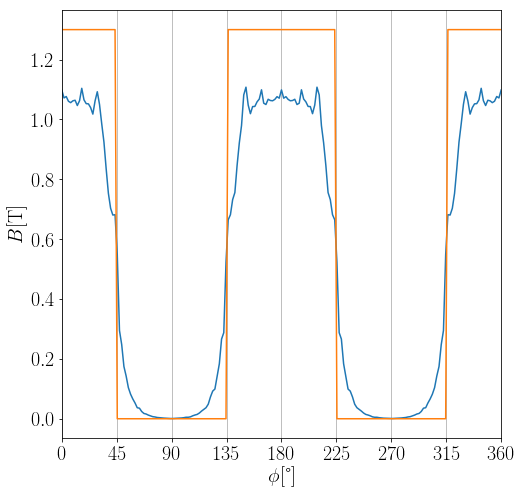

In [18]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig_g = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes_g = profile_fig_g.add_subplot(111)

teslamax_playground = str(Path.home() / "code" / "TeslaMax" / "teslamax-play" )

tmm_g = TeslaMaxModel(tmpd,
                      alpha_B_rem_g,
                      path=teslamax_playground)
tmm_g.run()
phi_vector_g, B_vector_g = tmm_g.get_profile_data().T

profile_axes_g.plot(phi_vector_g,B_vector_g)
profile_axes_g.set_xlim(0,np.max(phi_vector_g))
profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector_g),9))
profile_axes_g.xaxis.grid(True)
profile_axes_g.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes_g.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = teslamax.calculate_instantaneous_profile(phi_vector_g,teslamax.TARGET_PROFILE)
profile_axes_g.plot(phi_vector_g,B_inst_vector)

save_figure(profile_fig_g,"profile_optimized_B_13")

In [19]:
teslamax.calculate_average_high_field(tmm_g.get_profile_data())

0.96483319222222219

In [20]:
tmpd.calculate_functional_gradient(alpha_B_rem_g)

array([  3.55271368e-08,  -1.77635684e-07,   3.37507799e-07,
        -1.51345603e-06,   1.18660637e-06,   1.77635684e-08])

In [21]:
np.linalg.eigvals(tmpd.calculate_functional_hessian(alpha_B_rem_g))

array([  1.90816926e-02,  -1.07178858e-02,   1.07662673e-02,
         3.16178024e-03,  -9.75572224e-04,   1.35626784e-19])

## Optimization using evolutionary algorithms

In [ ]:
from scipy.optimize import differential_evolution, basinhopping

In [ ]:
params_optimization = {"R_i": 0.015,
                "R_o": 0.070,
                "h_gap": 0.020,
                "R_s": 0.140,
                "h_fc": 0.010,
                "R_e": 2,
                "n_IV": 3,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "B_rem_II_1": 1.4,
                "B_rem_II_2": 1.4,
                "B_rem_II_3": 1.4,
                "mu_r_II": 1.05,
                "B_rem_IV_1": 1.4,
                "B_rem_IV_2": 1.4,
                "B_rem_IV_3": 1.4,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }
alpha_B_rem_0 = [15,30,45,15,45,135]

n = len(alpha_B_rem_0)

tmpd = TeslaMaxPreDesign(params_optimization)

In [ ]:
%%time 
## all this methods from the TeslaMaxPreDesign class accept as only arguments the design vector (with remanence angles)

objective_function = tmpd.calculate_functional

bounds = [(0.0, 360.0) for i in range(0,n)]

res = differential_evolution(objective_function,bounds,disp=True)

In [ ]:
res.x

In [ ]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
profile_axes = profile_fig.add_subplot(111)


teslamax_playground = 'C:\\Users\\fabiofortkamp\\code\\TeslaMax\\teslamax-play'

tmm_optimized = TeslaMaxModel(tmpd,res.x,
                   path=teslamax_playground)
tmm_optimized.run()
phi_vector, B_vector = tmm_optimized.get_profile_data().T

profile_axes.plot(phi_vector,B_vector)
profile_axes.set_xlim(0,np.max(phi_vector))
profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
profile_axes.xaxis.grid(True)
profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
profile_axes.set_ylabel(r'$B [\si{\tesla}]$')

B_inst_vector = teslamax.calculate_instantaneous_profile(phi_vector,teslamax.TARGET_PROFILE)
profile_axes.plot(phi_vector,B_inst_vector)

save_figure(profile_fig,"profile_optimized_genetic_B_13")

In [ ]:
teslamax.calculate_average_high_field(tmm_optimized.get_profile_data())

In [ ]:
tmpd.calculate_functional_gradient(res.x)

In [ ]:
np.linalg.eigvals(tmpd.calculate_functional_hessian(res.x))